In [1]:
import tensorflow as tf
import numpy as np
from scipy import signal
from scipy import spatial
from IPython.display import Audio
from scipy.io import wavfile
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### single music classification and search
# import music
# randomly extract 10 seconds of audio from each music
# label each audio
# convert them to spectrograms
# encode the spectrograms into embeddings using neural network (training), method similar to Now Playing Fingerprint
# test

### multi music decomposition
# randomly superimpose 5 audio clips into one 10 second audio
# the label should contain information of all the 5 clips
# do the above dataset repetitively to create a dataset
# convert to spectrograms
# ???encode and train neural network, the output embedding should contain all the 5 audio information
# test

In [3]:
music = [wavfile.read(wav_files) for wav_files in glob('/Users/wjr/Desktop/temp/*.wav')]
num_music = 10
start = 60
end = 68
fs = 44100
for index in range(num_music):
    if music[index][0] != 44100:
        print('error')
    music[index] = music[index][1][start*fs:end*fs,0]
Audio(data=music[0], rate=fs)

In [4]:
num_embedding = 7
dataset = np.zeros(shape=(num_music, num_embedding, fs*2))
for i in range(num_music):
    dataset[i][0] = music[i][0:fs*2]
    dataset[i][1] = music[i][fs*2:fs*4]
    dataset[i][2] = music[i][fs*4:fs*6]
    dataset[i][3] = music[i][fs*6:]
    dataset[i][4] = music[i][fs:fs*3]
    dataset[i][5] = music[i][fs*3:fs*5]
    dataset[i][6] = music[i][fs*5:fs*7]
Audio(data=dataset[0][0], rate=fs)

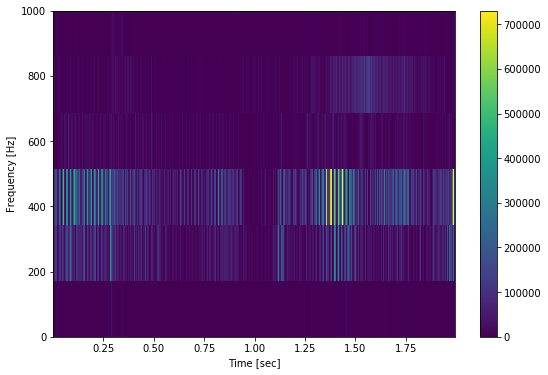

(129, 393)


In [5]:
frequencies, times, spectrogram = signal.spectrogram(dataset[0][0], fs)

plt.figure(figsize=(9,6))
plt.pcolormesh(times, frequencies, spectrogram)
plt.ylim([0, 1000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()
print(spectrogram.shape)

In [6]:
dataset.shape

(10, 7, 88200)

In [7]:
WIDTH = 128
HEIGHT = 384

train_data = np.zeros([num_music*num_embedding, WIDTH, HEIGHT])
temp_data = np.zeros([num_music*num_embedding, fs*2])
train_label = np.zeros(num_music*num_embedding)
for i in range(num_music):
    for j in range(num_embedding):
        temp_data[i*num_embedding+j] = dataset[i][j]
        train_label[i*num_embedding+j] = i

for i in range(len(temp_data)):
    freq, t, spec = signal.spectrogram(temp_data[i], fs)
    train_data[i] = spec[:WIDTH, :HEIGHT]
    train_data[i] = train_data[i]/np.amax(train_data[i])
#print(np.amax(train_data))
train_data = train_data.astype(np.float32)

In [8]:
NUM_EMBEDDING = 4
MARGIN = 0.2
embedding_vec = np.random.rand(num_music, NUM_EMBEDDING)

# helper function for triplet loss
def diff(x,y):
    return tf.expand_dims(x, axis=1) - tf.expand_dims(y, axis=0)

def dist(x,y):
    diffs = diff(x,y)
    return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1))

def triplet_loss(dists, labels):
    identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                             tf.expand_dims(labels, axis=0))
    negative_mask = tf.logical_not(identity_mask)
    positive_mask = tf.logical_xor(identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + MARGIN, 0.0)


def model_fn(features, labels, mode):
    # input layer
    input_layer = tf.reshape(features["x"], [-1, WIDTH, HEIGHT, 1])
    
    # convolution layer 1
    conv11 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv12 = tf.layers.conv2d(
        inputs=conv11,
        filters=32,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv12, pool_size=[2,2], strides=2)
    
    # convolution layer 2
    conv21 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv22 = tf.layers.conv2d(
        inputs=conv21,
        filters=64,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 1
    pool2 = tf.layers.max_pooling2d(inputs=conv22, pool_size=[2,2], strides=2)
    
    ### more convolution layers here...
    
    # flatten
    flat = tf.layers.flatten(pool2)
    
    ### divide and encode...
    
    # final embedding
    embedding = tf.layers.dense(flat,
                                activation=None,
                                kernel_initializer=tf.truncated_normal_initializer,
                                units=NUM_EMBEDDING)
    
    # predict mode
    #similar = 1 - [spatial.distance.cosine(ref, embedding) for ref in embedding_vec]
    similar = tf.constant(1.0) - [tf.losses.cosine_distance(tf.nn.l2_normalize(ref, 0), tf.nn.l2_normalize(embedding[-1], 0), axis=0) for ref in embedding_vec]
    predictions = {
        "classes": tf.argmax(similar),
        "similarities": tf.convert_to_tensor(similar)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=tf.convert_to_tensor(embedding[-1]))
    
    # loss function
    dists = dist(embedding, embedding)
    loss = tf.reduce_mean(triplet_loss(dists, labels))
    
    # train mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)



In [11]:
recognizer = tf.estimator.Estimator(model_fn=model_fn)#, model_dir="./Desktop/temp/recognizer_model")

W0708 12:44:33.553298 4764886464 estimator.py:1811] Using temporary folder as model directory: /var/folders/zj/bx51k4xs5cl4_njz1xnst0fr0000gn/T/tmp4t1i3ieo


In [12]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_label,
    batch_size=70,
    num_epochs=1000,
    shuffle=True)
recognizer.train(input_fn=train_input_fn, steps=1)

W0708 12:44:40.235385 4764886464 deprecation.py:323] From /Users/wjr/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/training/monitored_session.py:875: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [13]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x":train_data[0]},
    shuffle=False)
result = recognizer.predict(input_fn=predict_input_fn)

# database embedding for the first piece
result = list(result)
result

[-0.93824255, 2.1614835, -0.07655146, -0.6328764]

In [14]:
# original track
test_original = dataset[0][0]
print(test_original)
Audio(data=test_original, rate=fs)

[-4858. -4513. -4458. ... -1874. -2517. -4569.]


In [15]:
noise = np.random.rand(fs*2)
test_noisy = test_original + (noise - 0.5) * 2500
print(test_noisy)
Audio(data=test_noisy, rate=fs)

[-4680.73057035 -3513.20686809 -5237.46019602 ... -1229.810505
 -2996.76133756 -3765.14651031]


In [16]:
def create_data(audio):
    _1, _2, ret = signal.spectrogram(audio, fs)
    ret = ret[:WIDTH, :HEIGHT]
    ret = ret/np.amax(ret)
    ret = ret.astype(np.float32)
    return ret

test_data = create_data(test_noisy)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x":test_data},
    shuffle=False)
noisy_result = recognizer.predict(input_fn=predict_input_fn)
noisy_result = list(noisy_result)
noisy_result

[-0.9360767, 2.142715, -0.07903869, -0.6392742]

In [17]:
cos_dist = 200 * spatial.distance.cosine(result, noisy_result)
print("similarity is: " + str(1-cos_dist))

similarity is: 0.9973058700561523


In [214]:
embedding_ref = []
for i in range(20):
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x":train_data[i]},
    shuffle=False)
    current = recognizer.predict(input_fn=predict_input_fn)
    embedding_ref.append(list(current))

In [228]:
sim_array = np.zeros(len(embedding_ref))
for i in range(len(embedding_ref)):
    sim_array[i] = 1 - spatial.distance.cosine(embedding_ref[i], noisy_result)
sim_array

array([0.99999541, 0.99557614, 0.99486011, 0.996499  , 0.99609864,
       0.99494797, 0.99612564, 0.99499881, 0.99664843, 0.99585873,
       0.99676496, 0.99654698, 0.99634016, 0.99551737, 0.99583972,
       0.9963125 , 0.99653149, 0.99659669, 0.99648255, 0.99534911])

Text(0.5,1,'embedding 64')

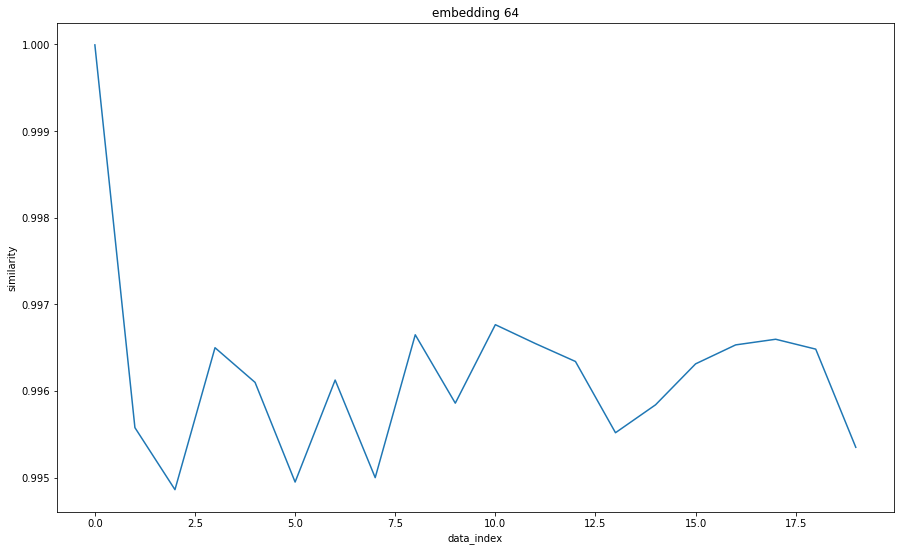

In [233]:
embedding_64 = sim_array
plt.figure(figsize=(15,9))
plt.plot(embedding_64)
plt.ylabel('similarity')
plt.xlabel('data_index')
plt.title('embedding 64')

In [18]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x":test_data},
    shuffle=False)
noisy_result = recognizer.predict(input_fn=predict_input_fn)
noisy_result = list(noisy_result)
embedding_ref = []
for i in range(20):
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x":train_data[i]},
    shuffle=False)
    current = recognizer.predict(input_fn=predict_input_fn)
    embedding_ref.append(list(current))

Text(0.5,1,'embedding 4')

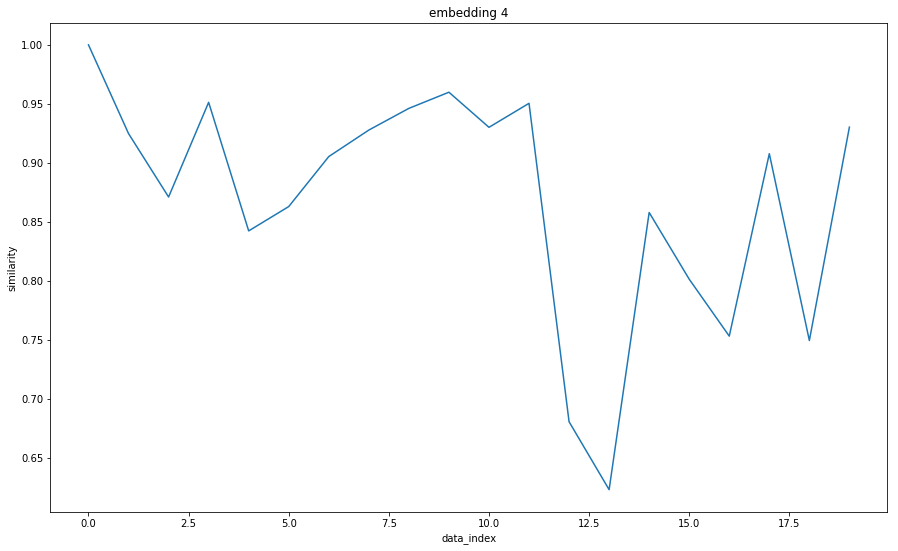

In [19]:
sim_array = np.zeros(len(embedding_ref))
for i in range(len(embedding_ref)):
    sim_array[i] = 1 - spatial.distance.cosine(embedding_ref[i], noisy_result)
embedding_4 = sim_array
plt.figure(figsize=(15,9))
plt.plot(embedding_4)
plt.ylabel('similarity')
plt.xlabel('data_index')
plt.title('embedding 4')